<a href="https://colab.research.google.com/github/AlexanderFriedrichsen/DeepFakeABM_GoogleCollabClone/blob/main/DeepFakeSpreadABM_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepFake Agent Based Modeling

Code authored by Alex Friedrichsen and Gabriela Salazar-Lopez. 

Some modeling decisions

activation time: RandomActivation is our choice for activation time as opposed to one state of node going first, in real life it doesn't make sense that one state would watch a video or spread a video before any other.

In [ ]:
!pip install mesa

import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import random as random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx

     |████████████████████████████████| 668 kB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 


In [ ]:
def gen_probs(catego):
    """
    Catego can be:
      - all_equals
      - male_has_core_periphery
    """
    if catego == 'all_equals':
        sizes = [75, 75, 75, 75]
        probs = [[0.2, 0.001, 0.001, 0.001],
                 [0.001, 0.2, 0.001, 0.001],
                 [0.001, 0.001, 0.2, 0.001],
                 [0.001, 0.001, 0.001, 0.2]]
    elif catego == 'male_has_core_periphery':
        sizes = [40, 20, 80, 80, 80]
        probs = [[0.3, 0.01, 0.001, 0.001, 0.001],
                 [0.01, 0.2, 0.001, 0.001, 0.001],
                 [0.001, 0.001, 0.2, 0.001, 0.001],
                 [0.001, 0.001, 0.001, 0.2, 0.001],
                 [0.001, 0.001, 0.001, 0.001, 0.2]]
    elif catego == 'white_mainstream':
        sizes = [120, 120, 30, 30]
        probs = [[0.3, 0.05, 0.001, 0.001],
                 [0.05, 0.3, 0.001, 0.001],
                 [0.001, 0.001, 0.2, 0.001],
                 [0.001, 0.001, 0.001, 0.2]]

    return sizes, probs

In [ ]:
class Belief_State(enum.IntEnum):
    DUPED = 0
    NEUTRAL = 1
    INFORMED = 2
    NAIVE = 3

In [ ]:
class Race(enum.IntEnum):
    WHITE = 0
    NONWHITE = 1

In [ ]:
class Gender(enum.IntEnum):
    FEMALE = 0
    MALE = 1
    NONBINARY = 2

In [ ]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.age = int(self.random.normalvariate(20,40))
        self.gender = (Gender)(np.random.choice([Gender.FEMALE, Gender.MALE, Gender.NONBINARY], p=[0.45, 0.45, 0.1]))
        self.race = (Race)(np.random.choice([Race.WHITE, Race.NONWHITE], p=[0.8, 0.2]))
        self.belief_state = Belief_State.NAIVE
        self.videoGender = model.videoGender
        self.videoRace = model.videoRace
        #self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False)
        # if self.model.grid.is_cell_empty(node)          #THIS MAKES IT SO IT DOESN'T MOVE SINCE NETWORK IS FULL, TAKE IT OUT AND THEY MOVE
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)       


    def contact(self):
        """post video and see if anyone watches it, then change their belief_state if they did"""
        # if self.belief_state == Belief_State.DUPED: REMOVE THIS FOR NOW?
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        # naive_neighbors = [
        #     agent
        #     for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
        #     if agent.belief_state is Belief_State.NAIVE
        # ]
        neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
        ]
        #should this be self.random.random
        for a in neighbors:
            finalPDuped = model.pDuped
            #if the neighbor watches the video (again):
            if a.belief_state == Belief_State.DUPED:
                finalPDuped *= model.pStayDuped
            #elif a.belief_state == Belief_State.NEUTRAL:
                #do nothing, prob of becoming duped on second watch stays the same
            elif a.belief_state == Belief_State.INFORMED:
                finalPDuped *= model.pStayInformed
            if (random.random() < model.pWatch) and (model.flags < model.flagsThreshold):
                #if gender of neighbor matches gender of video
                if a.gender == self.videoGender:
                    finalPDuped = model.pDuped * model.genderMatchMult
                #if race of neighbor matches race of video
                if a.race == self.videoRace:
                    finalPDuped *= model.raceMatchMult
                
                if random.random() < finalPDuped:
                    a.belief_state = Belief_State.DUPED
                else:
                    if random.random() < model.pNeutral:
                        #become neutral
                        a.belief_state = Belief_State.NEUTRAL
                    else:
                        a.belief_state = Belief_State.INFORMED
                        if random.random() < model.pFlag:
                            model.flags += 1
            #else: they stay whatever state they were before
      
    def step(self):
        #self.status()
        self.move()
        self.contact()
        
    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)

## DeepFake Spread Model

In [ ]:
def get_flags(model):
  return(model.flags)

In [ ]:
def get_network (model):
  return(model.G)

In [ ]:
class DeepFakeSpreadModel(Model):
    """A model for DeepFake spread in a social network"""
    

    def __init__(self, N=10, pDuped=0.5, pWatch=.01, pNeutral = 0.2, 
                 avg_node_degree=3, genderMatchMult = .1, raceMatchMult = .1, 
                 initialDupedProb = 0.01, pStayDuped = 1.5, pStayInformed = .5,
                 flags=0, flagsThreshold = 1000, pFlag = 0.03, pref_attach_edges=3,
                 videoGender = Gender.MALE, videoRace = Race.WHITE):

        self.initialDupedProb = initialDupedProb

        self.videoGender = videoGender
        self.videoRace = videoRace

        # pWatch is probability a neighbor watches the video. 
        self.pWatch = pWatch
        # PDuped is base probability they fall for the fake
        self.pDuped = pDuped
        # genderMatchMult is the change in pDuped if share gender with video

        #for subsequent video wathes
        self.pStayDuped = pStayDuped
        self.pStayInformed = pStayInformed


        self.genderMatchMult = genderMatchMult
        # raceMatchMult is the change in pDuped if share race with video
        self.raceMatchMult = raceMatchMult
        #pNeutral is the probability a non-duped watcher becomes neutral (or a INFORMED)
        self.pNeutral = pNeutral

        self.pFlag = pFlag
        self.flags = flags
        self.flagsThreshold = flagsThreshold

        #self.num_agents = N
        self.num_nodes = N  
        prob = avg_node_degree / self.num_nodes

        # Make the initial network. 
        # In future shoudl change this to be our actual social network?
        # self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        sizes, probs = gen_probs('all_equals')
        self.G = nx.stochastic_block_model(sizes, probs, seed=0)
        #self.G = nx.barabasi_albert_graph(n=self.num_nodes, m=pref_attach_edges)
        self.G.remove_edges_from(list(nx.selfloop_edges(self.G)))
        self.grid = NetworkGrid(self.G)
        
        self.schedule = RandomActivation(self)
        self.running = True
        
        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents duped at start
            duped = np.random.choice([0,1], p=[1-initialDupedProb,initialDupedProb])
            if duped == 1:
                a.belief_state = Belief_State.DUPED
            
        self.datacollector = DataCollector(model_reporters={"Flags": get_flags}, 
                                           agent_reporters={"Gender": lambda g: g.gender, "Belief_State": lambda b: b.belief_state, "Race": lambda r: r.race,
                                                            "Position": lambda a: a.pos})
        #"Belief_State": "belief_state", 
        # self.datacollector = DataCollector(model_reporters={"Flags": get_flags}, agent_reporters={"Belief_State": "belief_state"})
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [ ]:
def get_column_data_by_race_gender(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe().reset_index()
    groups = ['Step', 'Gender', 'Race', 'Belief_State']
    agent_state = agent_state[groups]
    col = 'Belief_State'
    key = ['Step', 'Gender', 'Race']
    X = pd.pivot_table(agent_state, index=key, columns= col,
                       aggfunc=np.size, fill_value=0)
    labels = ["DUPED", "NEUTRAL", "INFORMED", "NAIVE"]
    X.columns = labels[:len(X.columns)]
    #replace numbers for strings for gender, race, belief_state to make it more legible
    X = X.reset_index()
    X = X.replace({'Gender': {0: 'FEMALE', 1: 'MALE', 2: 'NONBINARY'}})
    X = X.replace({'Race': {0: 'WHITE', 1: 'NONWHITE'}})
    # X = X.replace({'Belief_State': {0: 'DUPED', 1: 'NEUTRAL', 2: 'INFORMED', 3:'NAIVE'}})
    # #Add Flag Data
    # flags = model.datacollector.get_model_vars_dataframe()
    # X['FLAGS'] = np.zeros(len(X))
    # #X['FLAGS'] = flags
    return X


In [ ]:
#this one works
def plot_states(model):    
    steps = np.arange(model.schedule.steps)
    X = get_column_data_by_race_gender (model)
    totals_table = X.groupby(["Step"]).sum()
    flags = model.datacollector.get_model_vars_dataframe()
    totals_table = pd.concat([totals_table, flags], axis=1)
    genders = ['MALE', 'FEMALE', 'NONBINARY']
    races = ['WHITE', 'NONWHITE']
    states = ['NAIVE', 'DUPED', 'NEUTRAL', 'INFORMED']
    
    #make groups to graph
    groups_to_graph = []
    for r in races:
      for g in genders:
        group = []
        for s in states:
          group.append([r, g, s])
        groups_to_graph.append(group)

    fs = 14
    fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharex=False, sharey=False)
    ax = axes.ravel()

    #plot totals 
    for s in states:
      ax[0].plot(steps, totals_table[s], label=s)
    ax[0].plot(steps, totals_table.Flags, label='FLAGS', linestyle= 'dashed', color='gray')
    ax[0].set_title("TOTAL SPREAD", fontsize = fs)
    ax[0].legend(frameon=True, fontsize = fs, bbox_to_anchor=(1, 1))

    #plot by gender/race
    ylim = 1.05*(X.NAIVE.max())
    for a, g in zip (ax[3:], groups_to_graph):
      for i in g:
        state_data = X[i[2]][(X.Gender==i[1]) & (X.Race == i[0])]
        a.plot(steps, state_data, label=str(i[2]))
        a.set_title(i[0]+' '+ i[1], fontsize = fs)
        # a.set_ylim(top=250)
        a.set_ylim(top=ylim)
    
    #axis labels
    for a in np.arange (6, 9, 1):
      ax[a].set_xlabel('Steps', fontsize = fs)
    for a in np.arange (0, 9, 3):
      ax[a].set_ylabel('People', fontsize = fs)

    fig.delaxes(ax[1])
    fig.delaxes(ax[2])
  
    plt.show()
    return ()

In [ ]:
#RUN MODEL
pop=1000 #keep this at 1000
steps=400 #keep this at 200
st=time.time()
model = DeepFakeSpreadModel(N=pop, pDuped=1, raceMatchMult=0.6, genderMatchMult=0.6)
for i in range(steps):
    model.step()

In [ ]:
test = model.datacollector.get_agent_vars_dataframe().reset_index()
print(test)
print()
agentID_max = test.AgentID.max()
print(agentID_max)

        Step  AgentID  Gender  Belief_State  Race  Position
0          0        1       0             3     0         0
1          0        2       0             3     0         1
2          0        3       2             3     0         2
3          0        4       1             3     0         3
4          0        5       0             3     0         4
...      ...      ...     ...           ...   ...       ...
119995   399      296       0             0     0       228
119996   399      297       0             0     0       152
119997   399      298       2             2     0       144
119998   399      299       1             2     0        59
119999   399      300       0             0     0       202

[120000 rows x 6 columns]

300


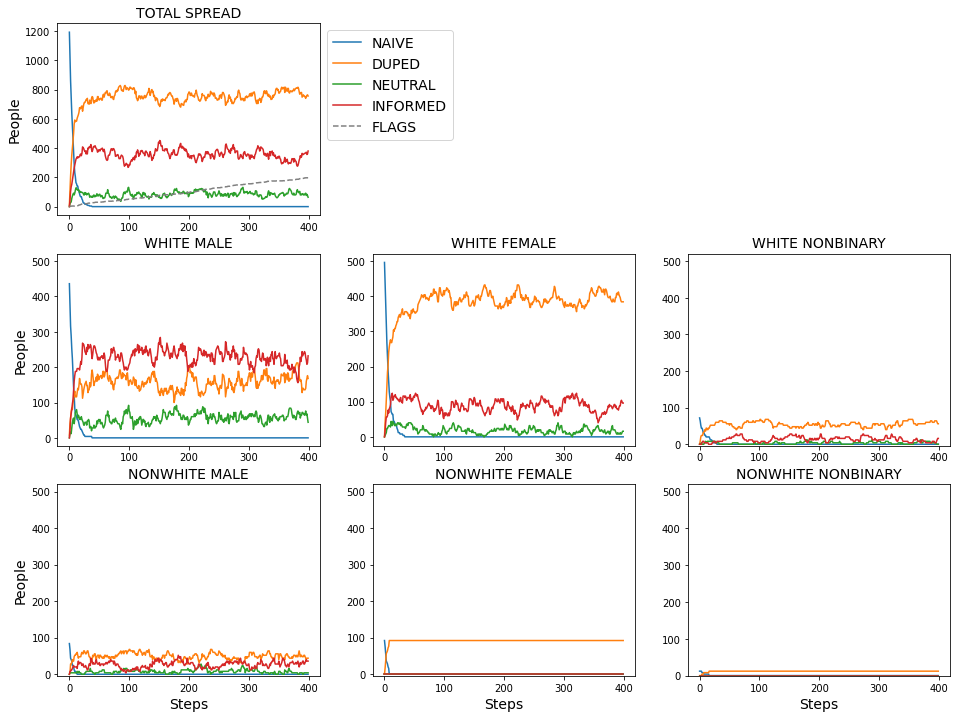

()

In [ ]:
plot_states(model)
#plt.savefig("fig.png", dpi=150)
#files.download("fig.png")

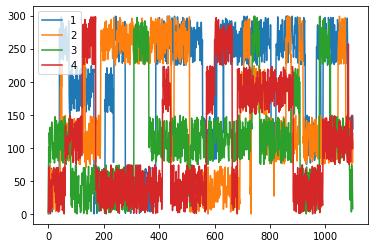

In [ ]:
#GRAPHS POSITIONS of a few nodes through the steps
test = model.datacollector.get_agent_vars_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
for aID in np.arange(1, 5):
  ax.plot(test.Step[test.AgentID==aID], test.Position[test.AgentID==aID], label=str(aID))
plt.legend()
plt.show()


In [ ]:
X=get_column_data_by_race_gender (model)
totals_table = X.groupby(["Step"]).sum()
print (totals_table)
print (totals_table.DUPED)

print(X.NAIVE)
print(X.NAIVE.max())

      DUPED  NEUTRAL  INFORMED  NAIVE
Step                                 
0        24        0         0   1176
1       104       12        52   1032
2       180       20        96    904
3       280       40       136    744
4       352       56       176    616
...     ...      ...       ...    ...
1095    764      120       316      0
1096    784      120       296      0
1097    784      108       308      0
1098    788      104       308      0
1099    788      100       312      0

[1100 rows x 4 columns]
Step
0        24
1       104
2       180
3       280
4       352
       ... 
1095    764
1096    784
1097    784
1098    788
1099    788
Name: DUPED, Length: 1100, dtype: int64
0       460
1        96
2       424
3       112
4        60
       ... 
6595      0
6596      0
6597      0
6598      0
6599      0
Name: NAIVE, Length: 6600, dtype: int64
460


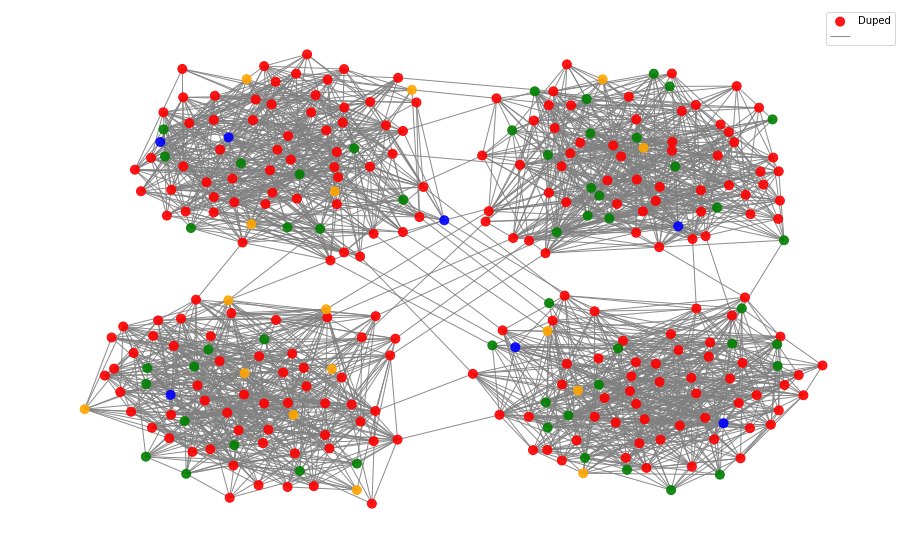

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["blue", "orange", "green", "red"])

def plot_grid(model,fig,layout='spring',title=''):
  graph = model.G
  if layout == 'kamada-kawai':      
      pos = nx.kamada_kawai_layout(graph)  
  elif layout == 'circular':
      pos = nx.circular_layout(graph)
  else:
      pos = nx.spring_layout(graph, iterations=5, seed=8)  
  plt.clf()
  ax=fig.add_subplot()
  states = [int(i.belief_state) for i in model.grid.get_all_cell_contents()]

  #cells = [(i.pos,int(i.state)) for i in model.grid.get_all_cell_contents()]
  #print (cells[:10])
  #print (pos)
  #print (pd.Series(states).value_counts())
  colors = [cmap(i) for i in states]
  
  nx.draw(graph, pos, node_size=80, edge_color='gray', node_color=colors, #with_labels=True,
          alpha=0.9,font_size=14,ax=ax)
  #print (ax.patches)
  ax.legend(['Duped','','R'])
  ax.set_title(title)
  return

fig,ax=plt.subplots(1,1,figsize=(16,10))
model = DeepFakeSpreadModel(60)
model.step();model.step()
f=plot_grid(model,fig,layout='kamada-kawai')
plt.savefig('abm_networkgrid.jpg')

In [ ]:
model = DeepFakeSpreadModel(1000)
model.step()
model
#model.datacollector.get_agent_vars_dataframe()
model.datacollector.get_model_vars_dataframe()

,Flags
0,0
